In [177]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from scipy.signal import butter, iirnotch, firwin, filtfilt, periodogram

In [178]:
from utils.signal_processing import *
# calculate tripolar laplacian from the given electrodes

In [179]:
import pyemgpipeline as pep

In [246]:
def data_from_files(data, metadata):
    sess_data = pd.read_csv(data,header=None)
    sess_metadata = pd.read_csv(metadata, names=['start_time','category'])
    category_instances = {}
    for i, row in sess_metadata.iterrows():
        start_time = row['start_time']
        category = row['category'].strip()
        end_time = sess_metadata.iloc[i + 1]['start_time'] if i < (len(sess_metadata) - 1) else sess_data.iloc[-1][0]

        channels = sess_data.loc[(sess_data[0] >= start_time) & (sess_data[0] < end_time)].iloc[:,[2,3,6,7]]
        instances = pd.DataFrame()
        instances['e1'] = tripolar_laplacian(channels[3],channels[2])
        instances['e2'] = tripolar_laplacian(channels[7],channels[6])

        if category not in category_instances:
            category_instances[category] = []
        category_instances[category].append(instances)
    return category_instances

In [209]:
def process_signal(signal):
    signal = np.array(signal)
    #signal = np.array(signal - signal.mean())
    emg = pep.wrappers.EMGMeasurement(signal, hz=250)
    emg.apply_dc_offset_remover()
    emg.apply_bandpass_filter(2,10,124)
    #emg.apply_full_wave_rectifier()
    #emg.apply_end_frame_cutter(n_end_frames=50)
    return emg

In [210]:
def plot_emg(cat_dict, category, instance, electrode, plot=True):
    signal = cat_dict[category][instance][electrode]
    emg = process_signal(signal)
    if plot:
        emg.plot()
        #plt.title(f'{category}: {instance}, electrode {electrode}')
    return emg

In [247]:
sess0_data = 'test_sess1_data.txt'
sess0_metadata = 'test_sess1_metadata.txt'
cat_instances = data_from_files(sess0_data, sess0_metadata)

In [237]:
sess_data = pd.read_csv(sess0_data,header=None)

In [245]:
sess_data.iloc[-1][0]

2331555.070999302

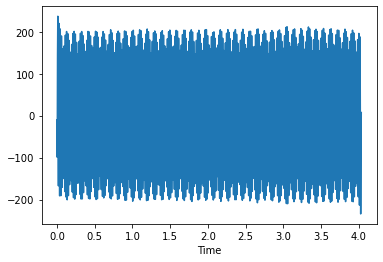

In [216]:
for i in range(1):
    plot_emg(cat_instances, 'REST', i, 'e2')

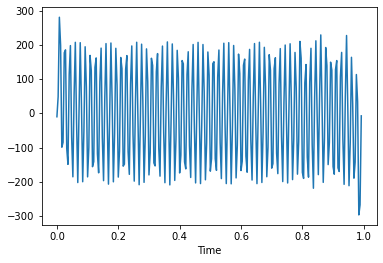

In [217]:
for i in range(1):
    emg_clench02 = plot_emg(cat_instances, 'CLENCH', i, 'e2')

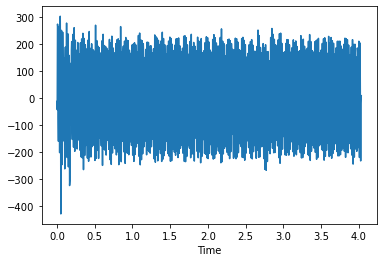

In [218]:
for i in range(1):
    emg_holdclench02 = plot_emg(cat_instances, 'HOLD CLENCH', i, 'e2')

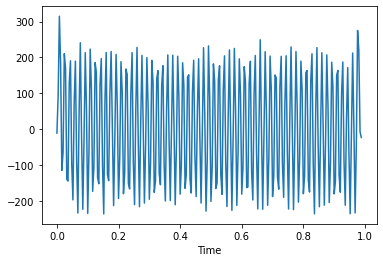

In [219]:
for i in range(1):
    emg_unclench02 = plot_emg(cat_instances, 'STOP CLENCH', i, 'e2')

In [188]:
from utils.features import *

In [228]:
def collect_feats(cat,num=10):
    feats = []
    for i in range(num):
        emg_data = plot_emg(cat_instances, cat, i, 'e1', plot=False).data
        zc = zero_crossings(emg_data)
        feats.append(zc)
    return feats

In [221]:
clench_feats = collect_feats(cat='CLENCH')

In [222]:
clench_feats

[119.0, 109.0, 115.0, 115.0, 120.0, 118.0, 119.0, 117.0, 124.0, 119.0]

In [223]:
rest_feats = collect_feats(cat='REST')

In [224]:
rest_feats

[483.0, 468.0, 472.0, 480.0, 486.0, 481.0, 481.0, 484.0, 483.0, 482.0]

In [225]:
hold_feats = collect_feats(cat='HOLD CLENCH')

In [226]:
hold_feats

[483.0, 475.0, 483.0, 482.0, 481.0, 478.0, 480.0, 467.0, 468.0, 482.0]

In [248]:
stop_feats = collect_feats(cat='STOP CLENCH')
stop_feats

[118.0, 110.0, 105.0, 107.0, 115.0, 111.0, 107.0, 107.0, 111.0, 118.0]